In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df = train_df.rename(columns={"profitable": "label"})
test_df = test_df.rename(columns={"profitable": "label"})

In [3]:
features = train_df.columns
sizeOfTrain = len(train_df)
# train_df.head()
features

Index(['price', 'maintenance', 'capacity', 'airbag', 'label'], dtype='object')

In [4]:
data = train_df.values
data

array([['low', 'low', 2, 'no', 'yes'],
       ['low', 'med', 4, 'yes', 'no'],
       ['low', 'high', 4, 'no', 'no'],
       ['med', 'med', 4, 'no', 'no'],
       ['med', 'med', 4, 'yes', 'yes'],
       ['med', 'high', 2, 'yes', 'no'],
       ['high', 'med', 4, 'yes', 'yes'],
       ['high', 'high', 2, 'yes', 'no'],
       ['high', 'high', 5, 'yes', 'yes']], dtype=object)

In [5]:
def end_tree(data):
    target_varaible = data[:, -1]
    possible_splits = np.unique(target_varaible)
    if len(possible_splits) == 1:
        return True
    else:
        return False

In [6]:
def class_prediction(data):    
    target_varaible = data[:, -1]
    possible_splits, count = np.unique(target_varaible, return_counts=True)
    i = count.argmax() #Maximum number of target class is assigned as the predicted value
    prediction = possible_splits[i] 
    return prediction

In [7]:
def possibleSplits(data):
    
    potential_splits = {}
    r, c = data.shape
    
    #Last column is the target variable. Thus iterating till penultimate column
    for i in range(c - 1):          
        values = data[:, i]
        uniqueValues = np.unique(values)      
        potential_splits[i] = uniqueValues
    
    return potential_splits

In [8]:
def split_data(data, indexOfSplitColumn, split_value):
    
    split_column_values = data[:, indexOfSplitColumn]

    dataLower = data[split_column_values == split_value]
    dataGreater = data[split_column_values != split_value]
    
    return dataLower, dataGreater

## Impurity (Information Gain & Gini Index)

In [9]:
def calculate_impurity(data_L, data_G, impurity_measure):
    
    targetColumn_L = data_L[:, -1]
    _, countOfUniqueV = np.unique(targetColumn_L, return_counts=True)
    pi = countOfUniqueV / countOfUniqueV.sum()
    entropy_1 = sum(-pi*np.log2(pi))
    gini_1 = 1 - sum(pi**2)
    
    targetColumn_G = data_G[:, -1]
    _, countOfUniqueV = np.unique(targetColumn_G, return_counts=True)
    pi = countOfUniqueV / countOfUniqueV.sum()
    entropy_2 = sum(-pi*np.log2(pi))
    gini_2 = 1 - sum(pi**2)
    
    #To be used in for information gain based splitting
    entropy =  (len(data_L) * entropy_1 + len(data_G) * entropy_2) / (len(data_L) + len(data_G))
    
    #To be used in for gini-index based splitting
    gini =  (len(data_L) * gini_1 + len(data_G) * gini_2) / (len(data_L) + len(data_G))
    
    if impurity_measure == "IG":
        return entropy
    elif impurity_measure == "GINI":
#         print(gini)
        return gini
    else: 
        print("Error encountered in impurity measure\n")
        return -1

In [10]:
def find_best_split_IG(data, potential_splits, entropy_parent):
    
    impurity_measure = "IG"
    information_gain = -9999
    for i in potential_splits:
        for value in potential_splits[i]:
            data_L, data_G = split_data(data, i, value)
            entropy = calculate_impurity(data_L, data_G, impurity_measure)
            current_information_gain = entropy_parent - entropy
            
            if current_information_gain > information_gain:
                information_gain = current_information_gain
                split_feature_index = i
                split_feature_value = value
                entropy_new_parent = entropy
    
    return split_feature_index, split_feature_value, entropy_new_parent

In [11]:
def find_best_split_GINI(data, potential_splits):
    
    impurity_measure = "GINI"
    gini_index = 9999
    for i in potential_splits:
        for value in potential_splits[i]:
            data_L, data_G = split_data(data, i, value)
            current_gini_index = calculate_impurity(data_L, data_G, impurity_measure)
            
            if current_gini_index < gini_index:
                gini_index = current_gini_index
                split_feature_index = i
                split_feature_value = value
    
    return split_feature_index, split_feature_value

## Decision Tree Classifier built from Scratch

In [12]:
def DecisionTree(data, impurity_measure, entropy_parent = 0):
    if (end_tree(data)):
        predcition = class_prediction(data)
        return predcition
    else:    
        potential_splits = possibleSplits(data)
        
        if impurity_measure == "IG":
            split_column, split_value, entropy_parent = find_best_split_IG(data, potential_splits, entropy_parent)
        elif impurity_measure == "GINI":
            split_column, split_value = find_best_split_GINI(data, potential_splits)
        else: 
            print("Error encountered in impurity measure\n")
            return -1    
        
        data_below, data_above = split_data(data, split_column, split_value)

        if len(data_below) == 0 or len(data_above) == 0:
            predcition = class_prediction(data)
            return predcition
        feature_name = features[split_column]

        question = "{} = {}".format(feature_name, split_value)

        # Dictionary definition of sub-tree
        sub_tree = {question: []}
        
        yes_answer = DecisionTree(data_below, impurity_measure, entropy_parent)
        no_answer = DecisionTree(data_above, impurity_measure, entropy_parent)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        return sub_tree

## Print tree

In [13]:
def print_indent(n):
    temp = n
    if temp >= 1:
        print("\n", end = '')
    while n > 1:
        print("    ",end = '')
        n = n-1
    if temp >= 1:
        print("|", end = '')
    return

def print_tree(tree, counter = 0):
    
    if not isinstance(tree, dict):
        print(" : ", tree,end='')
    else:
            
        question = list(tree.keys())[0]
        feature_name, comparison_operator, value = question.split(" ")
        print_indent(counter)
        print(feature_name, " = ", value, end = '')
        left_sub_tree = tree[question][0]
        print_tree(left_sub_tree,counter)
        print_indent(counter)
        print(feature_name, " != ", value, end = '')
        right_sub_tree = tree[question][1]
        counter = counter + 1
        print_tree(right_sub_tree,counter)

## Model performance through Information Gain and Gini Index

In [14]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")
    if str(example[feature_name]) == value:
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [15]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, args=(tree,), axis=1)
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

### Information Gain

In [16]:
tree_IG = DecisionTree(data, 'IG')

In [41]:
test_df = pd.read_csv("test.csv")
test_df = test_df.rename(columns={"profitable": "label"})
accuracy = calculate_accuracy(test_df, tree_IG)
print(accuracy)
test_df

0.5


,price,maintenance,capacity,airbag,label,classification,classification_correct
0,med,high,5,no,yes,no,False
1,low,low,4,no,yes,yes,True


In [18]:
print_tree(tree_IG)

maintenance  =  low :  yesmaintenance  !=  low
|price  =  low :  no
|price  !=  low
    |capacity  =  2 :  no
    |capacity  !=  2
        |airbag  =  no :  no
        |airbag  !=  no :  yes

### Gini Index

In [19]:
tree_gini = DecisionTree(data, "GINI")

In [40]:
test_df = pd.read_csv("test.csv")
test_df = test_df.rename(columns={"profitable": "label"})
accuracy = calculate_accuracy(test_df, tree_gini)
print(accuracy)
test_df

1.0


,price,maintenance,capacity,airbag,label,classification,classification_correct
0,med,high,5,no,yes,yes,True
1,low,low,4,no,yes,yes,True


In [21]:
print_tree(tree_gini)

maintenance  =  low :  yesmaintenance  !=  low
|capacity  =  5 :  yes
|capacity  !=  5
    |maintenance  =  high :  no
    |maintenance  !=  high
        |price  =  high :  yes
        |price  !=  high
            |price  =  low :  no
            |price  !=  low
                |airbag  =  no :  no
                |airbag  !=  no :  yes

## Impurity value of the rood node

### Information Gain 

In [22]:
_,_,rootNode_IG = find_best_split_IG(data, possibleSplits(data), 0)
rootNode_IG

0.8483857803777467

The root node "INFORMATION GAIN" = 0.8484

### Gini Index

In [23]:
def root_GINI(data, potential_splits):
    impurity_measure = "GINI"
    gini_index = 9999
    for i in potential_splits:
        for value in potential_splits[i]:
            data_L, data_G = split_data(data, i, value)
            current_gini_index = calculate_impurity(data_L, data_G, impurity_measure)
            
            if current_gini_index < gini_index:
                gini_index = current_gini_index
    
    return gini_index

In [24]:
rootNode_gini = root_GINI(data, possibleSplits(data))
rootNode_gini

0.4166666666666667

The root node "GINI INDEX" = 0.4167

# Scikit Learn Model

In [25]:
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [26]:
def sum_cm(input):
    sum1 = 0
    for row in range (len(input)):
        for col in range(len(input[0])):
            sum1 = sum1 + input[row][col]
    return sum1
def diasum_cm(input):
    sum = 0
    for row in range(len(input)):
        sum = sum + input[row][row]
    return sum
def conf_accuracy_cm(input):
    return diasum_cm(input)/sum_cm(input)

In [27]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df = train_df.rename(columns={"profitable": "label"})
test_df = test_df.rename(columns={"profitable": "label"})

In [28]:
train_df.loc[train_df["label"]=='yes',"label"] = 1
train_df.loc[train_df["label"]=='no',"label"] = 0
train_df.loc[train_df["price"]=='high',"price"] = 2
train_df.loc[train_df["price"]=='med',"price"] = 1
train_df.loc[train_df["price"]=='low',"price"] = 0
train_df.loc[train_df["maintenance"]=='high',"maintenance"] = 2
train_df.loc[train_df["maintenance"]=='med',"maintenance"] = 1
train_df.loc[train_df["maintenance"]=='low',"maintenance"] = 0
train_df.loc[train_df["airbag"]=='yes',"airbag"] = 1
train_df.loc[train_df["airbag"]=='no',"airbag"] = 0
X_train = train_df.iloc[:,[0,1,2,3]].values
Y_train = train_df.iloc[:,[4]].values

In [29]:
test_df.loc[test_df["label"]=='yes',"label"] = 1
test_df.loc[test_df["price"]=='med',"price"] = 1
test_df.loc[test_df["price"]=='low',"price"] = 0
test_df.loc[test_df["maintenance"]=='high',"maintenance"] = 2
test_df.loc[test_df["maintenance"]=='low',"maintenance"] = 0
test_df.loc[test_df["airbag"]=='no',"airbag"] = 0
X_test = test_df.iloc[:,[0,1,2,3]].values
Y_test = test_df.iloc[:,[4]].values

### Information Gain

In [30]:
classifier_IG = tree.DecisionTreeClassifier(criterion='entropy')
classifier_IG.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
accuracies = cross_val_score(estimator=classifier_IG, X=X_train, y=Y_train)
print(accuracies.mean())
print(accuracies.std())

0.5555555555555555
0.0785674201318386


In [32]:
ypred_test_IG = classifier_IG.predict(X_test)

In [45]:
cm_IG = confusion_matrix(Y_test, ypred_test_IG)
conf_accuracy_cm(cm_IG)


0.5

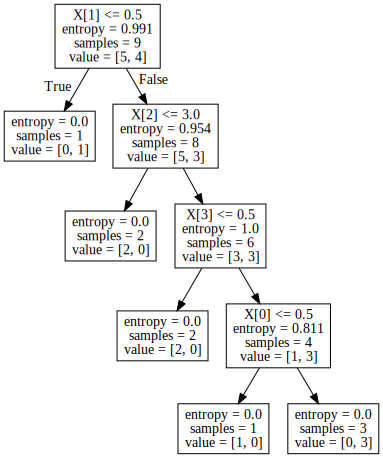

In [34]:
import graphviz 
dot_data = tree.export_graphviz(classifier_IG, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

The root node "INFORMATION GAIN" = 0.991

### Gini Index

In [35]:
classifier_gini = tree.DecisionTreeClassifier(criterion='gini')
classifier_gini.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
accuracies = cross_val_score(estimator=classifier_gini, X=X_train, y=Y_train)
print(accuracies.mean())
print(accuracies.std())

0.5555555555555555
0.0785674201318386


In [37]:
ypred_test_gini = classifier_gini.predict(X_test)

In [44]:
cm_gini = confusion_matrix(Y_test, ypred_test_gini)
conf_accuracy_cm(cm_gini)

1.0

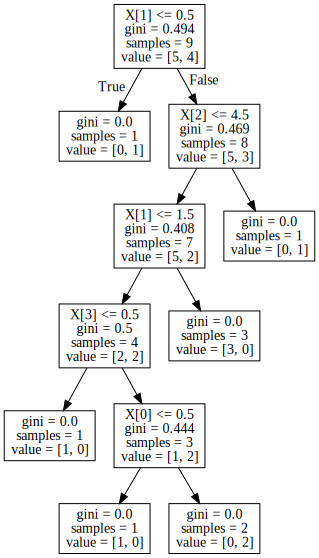

In [39]:
import graphviz 
dot_data = tree.export_graphviz(classifier_gini, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

The root node "GINI INDEX" = 0.494